In [2]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io
import os

In [3]:
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F


class ResDown(nn.Module):
    """
    Residual down sampling block for the encoder
    """
    def __init__(self, channel_in, channel_out, scale=2):
        super(ResDown, self).__init__()
        
        self.conv1 = nn.Conv2d(channel_in, channel_out//2, 3, 1, 1)
        self.BN1 = nn.BatchNorm2d(channel_out//2)
        self.conv2 = nn.Conv2d(channel_out//2, channel_out, 3, 1, 1)
        self.BN2 = nn.BatchNorm2d(channel_out)
        
        self.conv3 = nn.Conv2d(channel_in, channel_out, 3, 1, 1)

        self.AvePool = nn.AvgPool2d(scale, scale)
        
    def forward(self, x):
        skip = self.conv3(self.AvePool(x))
        
        x = F.rrelu(self.BN1(self.conv1(x)))
        x = self.AvePool(x)
        x = self.BN2(self.conv2(x))
        
        x = F.rrelu(x + skip)
        return x


class ResUp(nn.Module):
    """
    Residual up sampling block for the decoder
    """
    def __init__(self, channel_in, channel_out, scale=2):
        super(ResUp, self).__init__()
        
        self.conv1 = nn.Conv2d(channel_in, channel_out//2, 3, 1, 1)
        self.BN1 = nn.BatchNorm2d(channel_out//2)
        self.conv2 = nn.Conv2d(channel_out//2, channel_out, 3, 1, 1)
        self.BN2 = nn.BatchNorm2d(channel_out)
        
        self.conv3 = nn.Conv2d(channel_in, channel_out, 3, 1, 1)
        
        self.UpNN = nn.Upsample(scale_factor = scale,mode = "nearest")
        
    def forward(self, x):
        skip = self.conv3(self.UpNN(x))
        
        x = F.rrelu(self.BN1(self.conv1(x)))
        x = self.UpNN(x)
        x = self.BN2(self.conv2(x))
        
        x = F.rrelu(x + skip)
        return x
    

class Encoder(nn.Module):
    """
    Encoder block
    Built for a 3x64x64 image and will result in a latent vector of size z x 1 x 1
    As the network is fully convolutional it will work for images LARGER than 64
    For images sized 64 * n where n is a power of 2, (1, 2, 4, 8 etc) the latent feature map size will be z x n x n
    When in .eval() the Encoder will not sample from the distribution and will instead output mu as the encoding vector
    and log_var will be None
    """
    def __init__(self, channels, ch=64, z=512):
        super(Encoder, self).__init__()
        self.conv1 = ResDown(channels, ch)  # 64
        self.conv2 = ResDown(ch, 2*ch)  # 32
        self.conv3 = ResDown(2*ch, 4*ch)  # 16
        self.conv4 = ResDown(4*ch, 8*ch)  # 8
        self.conv5 = ResDown(8*ch, 8*ch)  # 4
        self.conv_mu = nn.Conv2d(8*ch, z, 2, 2)  # 2
        self.conv_log_var = nn.Conv2d(8*ch, z, 2, 2)  # 2

    def sample(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return mu + eps*std
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        if self.training:
            mu = self.conv_mu(x)
            log_var = self.conv_log_var(x)
            x = self.sample(mu, log_var)
        else:
            mu = self.conv_mu(x)
            x = mu
            log_var = None

        return x, mu, log_var


class Decoder(nn.Module):
    """
    Decoder block
    Built to be a mirror of the encoder block
    """

    def __init__(self, channels, ch=64, z=512):
        super(Decoder, self).__init__()
        self.conv1 = ResUp(z, ch*8)
        self.conv2 = ResUp(ch*8, ch*8)
        self.conv3 = ResUp(ch*8, ch*4)
        self.conv4 = ResUp(ch*4, ch*2)
        self.conv5 = ResUp(ch*2, ch)
        self.conv6 = ResUp(ch, ch//2)
        self.conv7 = nn.Conv2d(ch//2, channels, 3, 1, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)

        return x 


class VAE(nn.Module):
    """
    VAE network, uses the above encoder and decoder blocks
    """
    def __init__(self, channel_in, ch=64, z=512):
        super(VAE, self).__init__()
        """Res VAE Network
        channel_in  = number of channels of the image 
        z = the number of channels of the latent representation
        (for a 64x64 image this is the size of the latent vector)
        """
        
        self.encoder = Encoder(channel_in, ch=ch, z=z)
        self.decoder = Decoder(channel_in, ch=ch, z=z)

    def forward(self, x):
        encoding, mu, log_var = self.encoder(x)
        recon = self.decoder(encoding)
        return recon, mu, log_var

In [40]:
class PongDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_list = os.listdir(root_dir)

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.image_list[idx])
        print(img_name)
        image = io.imread(img_name)

        if self.transform:
            image = self.transform(image)

        return image

In [41]:
TRAIN_DATA_PATH = "/home/yangzhekong/Documents/wimblepong_/dataset/train"
TEST_DATA_PATH = "/home/yangzhekong/Documents/wimblepong_/dataset/test"
TRANSFORM_IMG = transforms.Compose([
    transforms.ToTensor()
    ])
RESIZE = transforms.Resize([256, 256])

train_data = PongDataset(root_dir=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
test_data = PongDataset(root_dir=TEST_DATA_PATH, transform=TRANSFORM_IMG)

In [46]:
test_data[100]

/home/yangzhekong/Documents/wimblepong_/dataset/test/5086.png


tensor([[[0.1294, 0.1294, 0.1294,  ..., 0.1294, 0.1294, 0.1294],
         [0.1294, 0.1294, 0.1294,  ..., 0.1294, 0.1294, 0.1294],
         [0.1294, 0.1294, 0.1294,  ..., 0.1294, 0.1294, 0.1294],
         ...,
         [0.1294, 0.1294, 0.1294,  ..., 0.1294, 0.1294, 0.1294],
         [0.1294, 0.1294, 0.1294,  ..., 0.1294, 0.1294, 0.1294],
         [0.1294, 0.1294, 0.1294,  ..., 0.1294, 0.1294, 0.1294]],

        [[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         ...,
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039]],

        [[0.1412, 0.1412, 0.1412,  ..., 0.1412, 0.1412, 0.1412],
         [0.1412, 0.1412, 0.1412,  ..., 0.1412, 0.1412, 0.1412],
         [0.1412, 0.1412, 0.1412,  ..., 0.1412, 0.1412, 0.

In [15]:
vae = VAE(3, 32, 128)
vae.load_state_dict(torch.load("/home/yangzhekong/Documents/wimblepong/models/vae_19.pkl", map_location=torch.device("cpu")))

<All keys matched successfully>

In [21]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

/home/yangzhekong/Documents/wimblepong_/dataset/train/19403.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


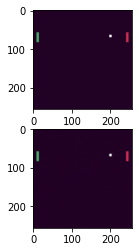

In [48]:
images = train_data[0]
images = RESIZE(images)
recon_images, mu, logvar = vae(images.unsqueeze(0))
# io.imshow(recon_images.squeeze().permute(1, 2, 0).detach().numpy())
fig, ax = plt.subplots(2, 1)
ax[1].imshow(recon_images.squeeze().permute(1, 2, 0).detach().numpy())
ax[0].imshow(images.squeeze().permute(1, 2, 0).detach().numpy())
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/home/yangzhekong/Documents/wimblepong_/dataset/train/23213.png


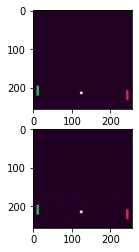

In [47]:
images = train_data[1]
images = RESIZE(images)
recon_images, mu, logvar = vae(images.unsqueeze(0))
# io.imshow(recon_images.squeeze().permute(1, 2, 0).detach().numpy())
fig, ax = plt.subplots(2, 1)
ax[1].imshow(recon_images.squeeze().permute(1, 2, 0).detach().numpy())
ax[0].imshow(images.squeeze().permute(1, 2, 0).detach().numpy())
plt.show()

/home/yangzhekong/Documents/wimblepong_/dataset/train/1111.png


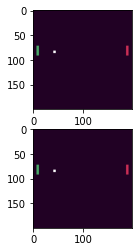

In [49]:
images = train_data[100]
fig, ax = plt.subplots(2, 1)
ax[1].imshow(images.squeeze().permute(1, 2, 0).detach().numpy())
ax[0].imshow(images.squeeze().permute(1, 2, 0).detach().numpy())
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/home/yangzhekong/Documents/wimblepong_/dataset/train/1238.png


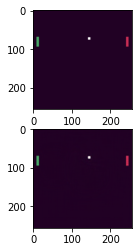

In [53]:
images = train_data[103]
images = RESIZE(images)
recon_images, mu, logvar = vae(images.unsqueeze(0))
# io.imshow(recon_images.squeeze().permute(1, 2, 0).detach().numpy())
fig, ax = plt.subplots(2, 1)
ax[1].imshow(recon_images.squeeze().permute(1, 2, 0).detach().numpy())
ax[0].imshow(images.squeeze().permute(1, 2, 0).detach().numpy())
plt.show()